In [1]:
import os
import word2vec
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

## Download toy corpus for wordvector training and example text

In [2]:
corpus_path = './text8'  # be sure your corpus is cleaned from punctuation and lowercased
if not os.path.exists(corpus_path):
    !wget http://mattmahoney.net/dc/text8.zip
    !unzip {corpus_path}

links = {'tale2cities': 'https://www.gutenberg.org/files/98/98-0.txt',  # a tale of two cities
         'siddartha': 'http://www.gutenberg.org/cache/epub/2500/pg2500.txt'}  # siddartha
for link in links.values():
    text_path = link.split('/')[-1]
    if not os.path.exists(text_path):
        !wget {link}

## Train wordvectors

In [3]:
wrdvec_path = 'wrdvecs-text8.bin'
if not os.path.exists(wrdvec_path):
    %time word2vec.word2vec(corpus_path, wrdvec_path, cbow=1, iter_=5, hs=1, threads=4, sample='1e-5', window=15, size=200, binary=1)

In [4]:
model = word2vec.load(wrdvec_path)
wrdvecs = pd.DataFrame(model.vectors, index=model.vocab)
del model
print(wrdvecs.shape)

(71291, 200)


## get sentence tokenizer

In [5]:
import nltk
nltk.download('punkt')
sentence_analyzer = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /usr/local/lib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## run get_penalty and split_optimal

In [6]:
%matplotlib inline
from textsplit.tools import get_penalty, get_segments
from textsplit.algorithm import split_optimal, split_greedy, get_total

penalty 4.07
1558 sentences, 71 segments, avg 21.94 sentences per segment
optimal score 16303.06, greedy score 16285.54
ratio of scores 1.0011


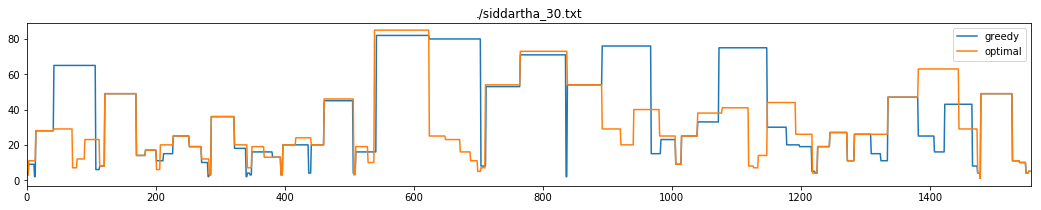

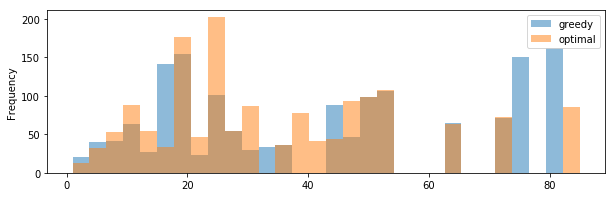

In [7]:
book = 'siddartha'
link = links[book]
# link = links['tale2cities']
segment_len = 30  # segment target length in sentences
segmented_text_path = './%s_%d.txt' % (book, segment_len)
book_path = link.split('/')[-1]

with open(book_path, 'rt') as f:
    text = f.read().replace('\n', '¤')  # punkt tokenizer handles newlines not so nice

sentenced_text = sentence_analyzer.tokenize(text)
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(sentenced_text).dot(wrdvecs)

penalty = get_penalty([sentence_vectors], segment_len)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(sentenced_text, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(sentenced_text), len(segmented_text), len(sentenced_text) / len(segmented_text)))

with open(segmented_text_path, 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences).replace('¤', '\n')
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_str += '\n[%d sentences, %4.3f]' % (len(segment_sentences), gain)
        print(('%s\n8<' + '=' * 78) % segment_str, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(sentenced_text, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title=segmented_text_path)
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3))

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))